## Generating Woody Cover Fraction (WCF) on PNG Geomedians
- bring in external geomedian as xarray - generated from `Generating_geomedian_composites.ipynb`
- appling model manually for the moment
- NOTE: for EASI ASIA, need to use the instance with ML libraries

In [1]:
import datacube
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.drivers.netcdf import write_dataset_to_netcdf


from datacube.virtual import construct, Transformation, Measurement
import xarray as xr
import numpy as np
import copy
import pickle
import sys
sys.path.append("/home/jovyan/code/dea-notebooks/Tools")
from dea_tools.classification import sklearn_unflatten
from dea_tools.classification import sklearn_flatten

/env/lib/python3.10/site-packages/dea_tools/classification.py:34: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
nc_path = '../data/geomedian_test.nc'
model_pickle = '../data/wcf_pickle_sklearn_version_1.pickle'

In [3]:
ds = xr.open_dataset(nc_path)
ds.attrs['crs'] = 'EPSG:32755'

In [4]:
ds

<xarray.Dataset>
Dimensions:       (y: 372, x: 371)
Coordinates:
  * y             (y) float64 9.181e+06 9.181e+06 ... 9.192e+06 9.192e+06
  * x             (x) float64 2.24e+05 2.24e+05 2.24e+05 ... 2.13e+05 2.129e+05
    spatial_ref   int32 ...
Data variables:
    nbart_blue    (y, x) float32 ...
    nbart_green   (y, x) float32 ...
    nbart_red     (y, x) float32 ...
    nbart_nir     (y, x) float32 ...
    nbart_swir_1  (y, x) float32 ...
    nbart_swir_2  (y, x) float32 ...
    fmask         (y, x) float32 ...
Attributes:
    date_created:           2023-03-14T04:25:27.153495
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.8.1...
    geospatial_bounds:      POLYGON ((144.50009513984418 -7.40078066167498, 1...
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -7.40078066167498
    geospatial_lat_max:     -7.299356834131926
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     144.39933861780153
    geospatial_lon_max:     144.5006593450928
    geospatial_lon_units:   degrees_east
    crs:                    EPSG:32755

In [5]:
# rename bands, needed model predict
ds = ds.rename({
    "nbart_blue": "blue",
    "nbart_green": "red",
    "nbart_red": "green",
    "nbart_nir": "nir",
    "nbart_swir_1": "swir1",
    "nbart_swir_2": "swir2",
})

In [6]:
# Unpickle model
with open(model_pickle, "rb") as f:
    ml_model_dict = pickle.load(f)

/env/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/env/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
# apply the model and rebuild structure of xarray to same as input
data = ds.drop_vars(['fmask'])
flat = sklearn_flatten(data)
results = ml_model_dict.predict(flat)
predicted_wcf = (sklearn_unflatten(results,data).transpose())
predicted_wcf_ds = predicted_wcf.to_dataset(name='woody_cover').squeeze()

/env/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


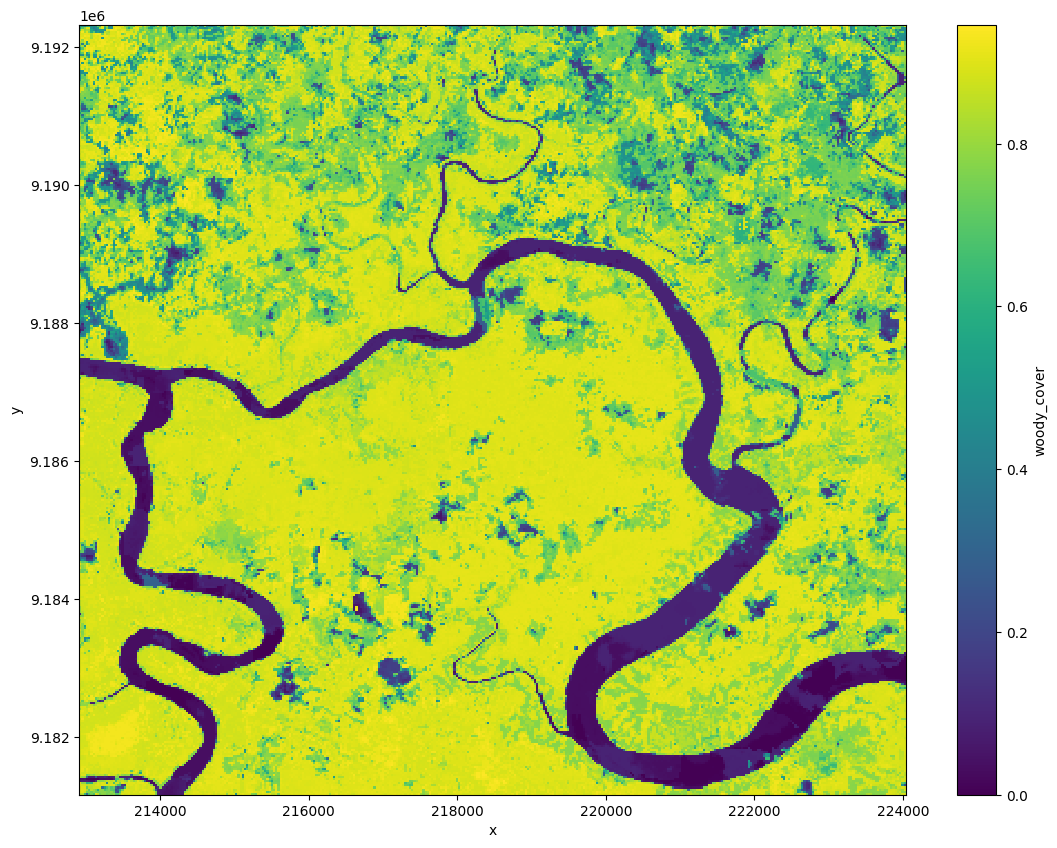

In [8]:
predicted_wcf_ds.woody_cover.plot(size=10)

In [9]:
# add crs and to_array for cog output
predicted_wcf_ds.attrs['crs'] = 'EPSG:32755'
predicted_wcf_ds_export = predicted_wcf_ds.to_array()

# output as cog
write_cog(predicted_wcf_ds_export, '../data/WCF_test.tif', overwrite=True)

# export out as .nc to allow load back in easily as xarray
write_dataset_to_netcdf(predicted_wcf_ds, '../data/WCF_test.nc')
